In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# AII

In [3]:
keywords = [
    'machine learning',
    'deep learning',
    'artificial intelligence',
    'reinforcement learning',
    'neural network',
    # 'image recognition',
    'computer vision',
    'natural language processing',
    # 'model training',
    # 'inference',
    # 'hyperparameter',
    'speech processing',
    'control methods',
    'knowledge representation',
    'planning',
    'predictive analytics',
    'robotics',
]

In [4]:
patents = (
    pl.read_ndjson('datasets/bq-results-20240320-172635-1710955681787.json')
    .with_columns(pl.col('publication_date').str.slice(0, 4).cast(int).alias('year'))
    .to_pandas()
)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(lowercase=True, ngram_range=(1, 3), vocabulary=keywords, binary=True)
# X = vec.fit_transform(patents[patents['year'].ge(2015) & patents['year'].le(2020)].abstract.values)
X = vec.fit_transform(patents.abstract.values)

In [6]:
total = pd.DataFrame({
    'keywords': keywords,
    'freq': np.array(X.sum(axis=0)).flatten()
})
print(
    total.set_index('keywords')
    .style.to_latex()
)

\begin{tabular}{lr}
 & freq \\
keywords &  \\
machine learning & 25411 \\
deep learning & 15335 \\
artificial intelligence & 11497 \\
reinforcement learning & 1853 \\
neural network & 44322 \\
computer vision & 3262 \\
natural language processing & 1238 \\
speech processing & 302 \\
control methods & 282 \\
knowledge representation & 35 \\
planning & 4677 \\
predictive analytics & 77 \\
robotics & 163 \\
\end{tabular}



In [7]:
(X.sum(axis=1) != 0).sum(axis=0)

matrix([[94514]])

In [8]:
patent_mask = (np.array(X.sum(axis=1)) != 0).flatten()
year_mask = patents['year'].ge(2015) & patents['year'].le(2022)
country_mask = patents['country_code'].isin(['US', 'CN', 'KR', 'JP'])
patents = patents[
    patent_mask
    & year_mask
    & country_mask
].reset_index(drop=True).copy()

In [9]:
abstract_embeddings = np.load('datasets/all_abstract_embeddings.npy')
abstract_embeddings = abstract_embeddings[
    patent_mask
    & year_mask
    & country_mask
].copy()

In [10]:
assert patents.shape[0] == abstract_embeddings.shape[0]

In [11]:
task_ratings = pd.read_csv('datasets/db_26_3_text/Task Ratings.txt', sep='\t').query('`Scale ID` == "IM"')
task_statements = pd.read_csv('datasets/db_26_3_text/Task Statements.txt', sep='\t')
jobs = pd.read_csv('datasets/db_26_3_text/Occupation Data.txt', sep='\t')
jobs['SOC Code'] = jobs['O*NET-SOC Code'].str[:7]

In [12]:
tasks = pd.merge(
    task_ratings,
    task_statements[['O*NET-SOC Code', 'Task ID', 'Task']],
    how='left',
    on=['O*NET-SOC Code', 'Task ID']
)

In [13]:
tasks.shape

(17879, 13)

In [14]:
# task_embeddings = model.encode(tasks['Task'].values)
# np.save('datasets/task_embeddings_t5.npy', task_embeddings)
task_embeddings = np.load('datasets/task_embeddings_26_3.npy')

In [15]:
def compute_scores(task_embeddings, abstract_embeddings, tasks, jobs, aioe=None, threshold=0.8):
    similarity = cosine_similarity(
        task_embeddings,
        abstract_embeddings
    )

    task_df = tasks.copy()

    # threshold = task_df['similarity'].quantile(.95)
    task_df['similarity'] = similarity.max(axis=1)
    task_df['patent_index'] = similarity.argmax(axis=1)
    task_df['weight'] = task_df['Data Value'] / task_df.groupby('O*NET-SOC Code')['Data Value'].transform('sum')
    # task_df['similarity_t'] = task_df['similarity'] * (task_df['similarity'] > threshold).astype(int)
    # task_df['aii'] = task_df['similarity'] * task_df['weight']
    task_df['aii'] = task_df['similarity'].gt(threshold)

    jobs_aii = pd.merge(
        task_df.groupby('O*NET-SOC Code').agg({'aii': 'mean'}).reset_index(),
        jobs,
        how='left',
        on='O*NET-SOC Code'
    )

    if aioe is not None:
        data = pd.merge(
            aioe,
            jobs_aii.groupby('SOC Code').aii.mean().reset_index(),
            how='left',
            on='SOC Code'
        ).rename({'AIOE': 'aioe'}, axis=1)

        return data
    else:
        return jobs_aii

In [16]:
similarity = cosine_similarity(
    task_embeddings,
    abstract_embeddings
)

In [17]:
print(f"Tasks: {similarity.shape[0]:,.0f}")
print(f"Patents: {similarity.shape[1]:,.0f}")

Tasks: 17,879
Patents: 60,924


In [18]:
p_threshold = .90

tasks['similarity'] = similarity.max(axis=1)
tasks['patent_index'] = similarity.argmax(axis=1)
# tasks['weight'] = tasks['Data Value'] / tasks.groupby('O*NET-SOC Code')['Data Value'].transform('sum')
tasks['similarity_t'] = tasks['similarity'] * (tasks['similarity'] > tasks['similarity'].quantile(p_threshold)).astype(int)
tasks['s'] = tasks['similarity'].gt(tasks['similarity'].quantile(p_threshold))
# tasks['aii'] = tasks['similarity'] * tasks['weight']

In [19]:
print(f"Similarity threshold: {tasks['similarity'].quantile(p_threshold):.2f}")

Similarity threshold: 0.81


/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/aliakbars/miniforge3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


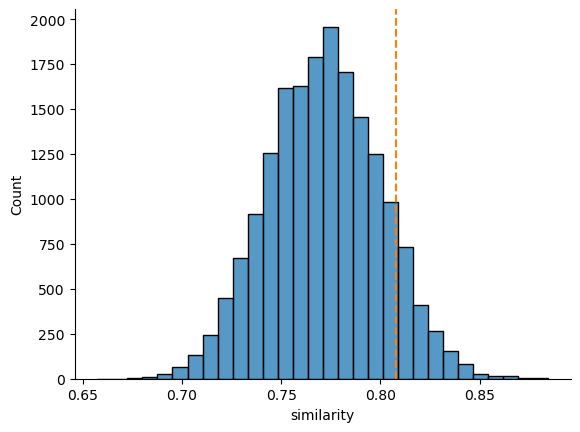

In [20]:
sns.histplot(x=tasks['similarity'], bins=30)
plt.axvline(tasks['similarity'].quantile(p_threshold), linestyle='--', c='C1')
sns.despine()

In [21]:
jobs_aii = (
    pl.from_dataframe(tasks)
    .group_by('O*NET-SOC Code')
    .agg(
        pl.col('s').mean().alias('aii'),
        pl.col('s').sum().alias('nb_impacted_tasks'),
        pl.col('s').count().alias('total_tasks'),
    )
    .join(
        pl.from_dataframe(jobs),
        how='left',
        on='O*NET-SOC Code'
    )
    .to_pandas()
)

In [22]:
aioe = pd.read_excel('datasets/AIOE_DataAppendix.xlsx', sheet_name='Appendix A')

In [23]:
# Joining the data with AIOE for comparison
data = (
    (
        pl.from_dataframe(jobs_aii)
        .group_by('SOC Code')
        .agg(
            pl.col('Title').first(),
            pl.col('nb_impacted_tasks').sum(),
            pl.col('total_tasks').sum(),
            pl.col('nb_impacted_tasks').sum().truediv(pl.col('total_tasks').sum()).alias('aii')
        )
    )
    .join(
        pl.from_dataframe(aioe),
        how='left',
        on='SOC Code'
    )
    .to_pandas()
).rename({'AIOE': 'aioe'}, axis=1)

In [24]:
data.head()

,SOC Code,Title,nb_impacted_tasks,total_tasks,aii,Occupation Title,aioe
0,25-1042,"Biological Science Teachers, Postsecondary",0,27,0.000000,"Biological Science Teachers, Postsecondary",1.227677
1,15-1299,Information Technology Project Managers,24,133,0.180451,None,NaN
2,19-4043,"Geological Technicians, Except Hydrologic Tech...",6,24,0.250000,None,NaN
3,11-3031,Treasurers and Controllers,0,63,0.000000,Financial Managers,1.446232
4,15-1253,Software Quality Assurance Analysts and Testers,4,27,0.148148,None,NaN


In [25]:
data['total_tasks'].describe()

count    759.000000
mean      23.555995
std       15.530011
min        4.000000
25%       16.000000
50%       20.000000
75%       26.000000
max      170.000000
Name: total_tasks, dtype: float64

In [26]:
tasks['SOC Code'] = tasks['O*NET-SOC Code'].str.slice(0, 7)

In [27]:
pd.DataFrame({
    'Highest scoring': data.nlargest(20, ['aii', 'total_tasks'])['Title'].reset_index(drop=True),
    'Lowest scoring': data.nsmallest(20, ['aii', 'total_tasks'])['Title'].reset_index(drop=True),
})

,Highest scoring,Lowest scoring
0,Nuclear Medicine Technologists,Pile Driver Operators
1,Sound Engineering Technicians,"Graders and Sorters, Agricultural Products"
2,Cardiovascular Technologists and Technicians,Floor Sanders and Finishers
3,Power Distributors and Dispatchers,Reinforcing Iron and Rebar Workers
4,Air Traffic Controllers,Insurance Underwriters
5,Magnetic Resonance Imaging Technologists,Administrative Services Managers
6,Electro-Mechanical and Mechatronics Technologi...,Farm Labor Contractors
7,Orthodontists,"Rock Splitters, Quarry"
8,Non-Destructive Testing Specialists,Brokerage Clerks
9,Remote Sensing Scientists and Technologists,"Pesticide Handlers, Sprayers, and Applicators,..."


In [28]:
print(pd.DataFrame({
    'Highest scoring': data.nlargest(20, ['aii', 'total_tasks'])['Title'].reset_index(drop=True),
    'Lowest scoring': data.nsmallest(20, ['aii', 'total_tasks'])['Title'].reset_index(drop=True),
}).style.to_latex())

\begin{tabular}{lll}
 & Highest scoring & Lowest scoring \\
0 & Nuclear Medicine Technologists & Pile Driver Operators \\
1 & Sound Engineering Technicians & Graders and Sorters, Agricultural Products \\
2 & Cardiovascular Technologists and Technicians & Floor Sanders and Finishers \\
3 & Power Distributors and Dispatchers & Reinforcing Iron and Rebar Workers \\
4 & Air Traffic Controllers & Insurance Underwriters \\
5 & Magnetic Resonance Imaging Technologists & Administrative Services Managers \\
6 & Electro-Mechanical and Mechatronics Technologists and Technicians & Farm Labor Contractors \\
7 & Orthodontists & Rock Splitters, Quarry \\
8 & Non-Destructive Testing Specialists & Brokerage Clerks \\
9 & Remote Sensing Scientists and Technologists & Pesticide Handlers, Sprayers, and Applicators, Vegetation \\
10 & Neurologists & Proofreaders and Copy Markers \\
11 & Machinists & Shipping, Receiving, and Inventory Clerks \\
12 & Special Effects Artists and Animators & Helpers--Painters,

In [29]:
aii = pl.read_csv('datasets/2022/aii.csv').to_pandas()

In [30]:
assert data.shape[0] == aii.shape[0]

In [34]:
joint = pd.merge(
    aii[['SOC Code', 'aii']],
    data[['SOC Code', 'Title', 'aii']],
    how='inner',
    on='SOC Code',
    suffixes=('', '_aug')
)

In [35]:
joint.to_csv('datasets/2022/aii_non_us.csv', index=False)

In [36]:
from scipy.stats import spearmanr, kendalltau

rho, pval = spearmanr(joint['aii_aug'], joint['aii'])
print(f"Spearman's r = {rho:.2f}")

Spearman's r = 0.90


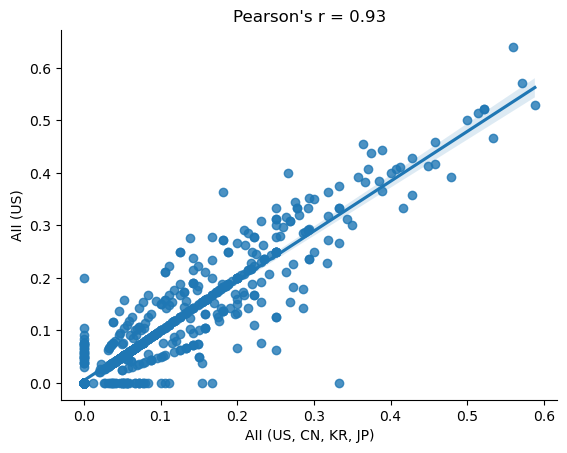

In [37]:
from scipy.stats import pearsonr

rho, pval = pearsonr(joint['aii_aug'], joint['aii'])
sns.regplot(
    x='aii_aug',
    y='aii',
    data=joint
)
plt.title(f"Pearson's r = {rho:.2f}")
plt.xlabel('AII (US, CN, KR, JP)')
plt.ylabel('AII (US)')
sns.despine()
plt.savefig('figures/2022/aii-non-us.pdf', bbox_inches='tight')

In [38]:
joint['aii_rank'] = joint['aii'].rank(method='dense')
joint['aii_aug_rank'] = joint['aii_aug'].rank(method='dense')
joint['rank_diff'] = joint['aii_rank'] - joint['aii_aug_rank']

In [39]:
joint.nlargest(10, 'rank_diff').set_index('Title')[['aii', 'aii_aug']].style.format('{:.2f}')

,aii,aii_aug
Title,,
"Pesticide Handlers, Sprayers, and Applicators, Vegetation",0.20,0.00
Amusement and Recreation Attendants,0.11,0.00
File Clerks,0.16,0.05
Mathematicians,0.36,0.18
"Earth Drillers, Except Oil and Gas",0.28,0.14
Travel Agents,0.25,0.12
Fabric and Apparel Patternmakers,0.25,0.12
Management Analysts,0.09,0.00
Animal Caretakers,0.14,0.05


In [40]:
from textwrap import shorten

joint.assign(
    title=joint['Title'].apply(lambda x: shorten(x, 50))
).nsmallest(10, 'rank_diff').set_index('title')[['aii', 'aii_aug']].style.format('{:.2f}')

,aii,aii_aug
title,,
Dredge Operators,0.00,0.33
Aircraft Cargo Handling Supervisors,0.00,0.17
"Lathe and Turning Machine Tool Setters, [...]",0.06,0.25
"Dispatchers, Except Police, Fire, and Ambulance",0.00,0.15
Rail-Track Laying and Maintenance Equipment [...],0.08,0.23
"Milling and Planing Machine Setters, [...]",0.07,0.20
Bakers,0.00,0.11
Solar Photovoltaic Installers,0.04,0.15
Medical Equipment Repairers,0.00,0.11


In [60]:
soc_code = data[data['Title'].str.contains("Solar Photovoltaic")].iloc[0,0]
it = tasks[tasks['SOC Code'].eq(soc_code) & tasks['s']]
patents.loc[it['patent_index'].values]

,publication_number,application_number,publication_date,country_code,title,abstract,year
40831,CN-111957047-A,CN-202010794440-A,20201120,CN,Checkpoint configuration data adjusting method...,The application discloses a checkpoint configu...,2020
17166,CN-114758002-B,CN-202210670391-A,20220902,CN,Photovoltaic string position determining metho...,The invention discloses a photovoltaic string ...,2022
12103,CN-114187260-A,CN-202111506090-A,20220315,CN,Photovoltaic module defect detection method an...,The invention provides a method and a system f...,2022
48927,CN-114758002-A,CN-202210670391-A,20220715,CN,Photovoltaic string position determining metho...,The invention discloses a method and a system ...,2022
